In [202]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.neighbors import LocalOutlierFactor

In [203]:
names = [
    "net profit / total assets",
    "total liabilities / total assets",
    "working capital / total assets",
    "current assets / short-term liabilitiesl",
    "[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365",
    "retained earnings / total assets",
    "EBIT / total assets",
    "book value of equity / total liabilities",
    "sales / total assets",
    "equity / total assets",
    "(gross profit + extraordinary items + financial expenses) / total assets",
    "gross profit / short-term liabilities",
    "(gross profit + depreciation) / sales",
    "(gross profit + interest) / total assets",
    "(total liabilities * 365) / (gross profit + depreciation)",
    "(gross profit + depreciation) / total liabilities",
    "total assets / total liabilities",
    "gross profit / total assets",
    "gross profit / sales",
    "(inventory * 365) / sales",
    "sales (n) / sales (n-1)",
    "profit on operating activities / total assets",
    "net profit / sales",
    "gross profit (in 3 years) / total assets",
    "(equity - share capital) / total assets",
    "(net profit + depreciation) / total liabilities",
    "profit on operating activities / financial expenses",
    "working capital / fixed assets",
    "logarithm of total assets",
    "(total liabilities - cash) / sales",
    "(gross profit + interest) / sales",
    "(current liabilities * 365) / cost of products sold",
    "operating expenses / short-term liabilities",
    "operating expenses / total liabilities",
    "profit on sales / total assets",
    "total sales / total assets",
    "(current assets - inventories) / long-term liabilities",
    "constant capital / total assets",
    "profit on sales / sales",
    "(current assets - inventory - receivables) / short-term liabilities",
    "total liabilities / ((profit on operating activities + depreciation) * (12/365))",
    "profit on operating activities / sales",
    "rotation receivables + inventory turnover in days",
    "(receivables * 365) / sales",
    "net profit / inventory",
    "(current assets - inventory) / short-term liabilities",
    "(inventory * 365) / cost of products sold",
    "EBITDA (profit on operating activities - depreciation) / total assets",
    "EBITDA (profit on operating activities - depreciation) / sales",
    "current assets / total liabilities",
    "short-term liabilities / total assets",
    "(short-term liabilities * 365) / cost of products sold)",
    "equity / fixed assets",
    "constant capital / fixed assets",
    "working capita",
    "(sales - cost of products sold) / sales",
    "(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)",
    "total costs /total sales",
    "long-term liabilities / equity",
    "sales / inventory",
    "sales / receivables",
    "(short-term liabilities *365) / sales",
    "sales / short-term liabilities",
    "sales / fixed assets",
    "class (0,1)",
]

In [204]:
df_year1 = pd.read_table("1year.csv", names=names, sep=",")
df_year2 = pd.read_table("2year.csv", names=names, sep=",")
df_year3 = pd.read_table("3year.csv", names=names, sep=",")
df_year4 = pd.read_table("4year.csv", names=names, sep=",")
df_year5 = pd.read_table("5year.csv", names=names, sep=",")

c:\Users\ep20254\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3221: DtypeWarning: Columns (0,1,2,5,6,8,9,10,13,17,21,23,24,28,34,35,37,47,50,54,56,58) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\Users\ep20254\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3221: DtypeWarning: Columns (14,23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\Users\ep20254\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3221: DtypeWarning: Columns (0,1,2,5,6,7,9,10,13,14,15,16,17,21,23,24,25,28,33,34,35,37,47,49,50,56,58) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [205]:
def devide_by_bankruptcy(dataFrame: pd.DataFrame):
    bankrupted = pd.to_numeric(df_year1[names[64]], errors="coerce")
    bankrupt_count = int(bankrupted.sum())
    all_count = len(dataFrame.index)
    return (dataFrame[-bankrupt_count:], dataFrame[: all_count - bankrupt_count])


def convert_column(series: pd.Series):
    converted = pd.to_numeric(series, errors="coerce", downcast="float")
    return converted


def find_most_impactful_columns_from_year(dataFrame: pd.DataFrame):
    bankrupted, not_bankrupted = devide_by_bankruptcy(dataFrame)
    impactful_columns = []

    for column in bankrupted.columns:
        if column == names[64]:
            continue
        mean = convert_column(dataFrame[column]).mean()
        bankrupted_mean = convert_column(bankrupted[column]).mean()
        not_bankrupted_mean = convert_column(not_bankrupted[column]).mean()
        diff = abs(abs(bankrupted_mean - not_bankrupted_mean) / mean * 100)
        impactful_columns.append((column, diff))

    impactful_columns.sort(key=lambda x: x[1], reverse=True)

    return impactful_columns


def find_most_impactful_columns(*years: pd.DataFrame):
    years_columns = []
    for year in years:
        result = find_most_impactful_columns_from_year(year)
        years_columns.append(result)

    column_diffs = {}
    for year, columns in zip(years, years_columns):
        for col, diff in columns:
            column_diffs[col] = column_diffs.get(col, []) + [diff]

    impactful_columns = []
    for col, diffs in column_diffs.items():
        avg_diff = sum(diffs) / len(diffs)
        impactful_columns.append((col, avg_diff))

    impactful_columns.sort(key=lambda x: x[1], reverse=True)

    return [col for col in impactful_columns if col[1] > 110]

Funkcja oblicza różnicę w średnich wartościach danej kolumny pomiędzy zbankrutowanymi i nie zbankrutowanymi firmami, a następnie normalizuje ją ze średnią kolumny dla wszystkich firm, aby uzyskać różnicę procentową. Ta różnica procentowa jest następnie dodawana do listy dla tej kolumny, aby później uśrednić ją dla wszystkich lat

In [206]:
impactful_columns = find_most_impactful_columns(
    df_year1, df_year2, df_year3, df_year4, df_year5
)

print("Most impactful columns:")
for column in impactful_columns:
    print(column[0], ":", column[1], "%")

Most impactful columns:
profit on operating activities / total assets : 7900.9428191185 %
profit on sales / total assets : 5149.1054129600525 %
[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365 : 4611.703786849976 %
(gross profit + extraordinary items + financial expenses) / total assets : 3840.548369884491 %
retained earnings / total assets : 3572.099142074585 %
gross profit / short-term liabilities : 2397.876564860344 %
net profit / total assets : 1972.9210424423218 %
EBITDA (profit on operating activities - depreciation) / total assets : 1764.5997369289398 %
working capital / total assets : 1312.493622303009 %
(net profit + depreciation) / total liabilities : 1074.601225554943 %
profit on sales / sales : 849.3782830238342 %
(gross profit + depreciation) / total liabilities : 832.4051183462143 %
(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation) : 830.1802814006805 %
(sales - 

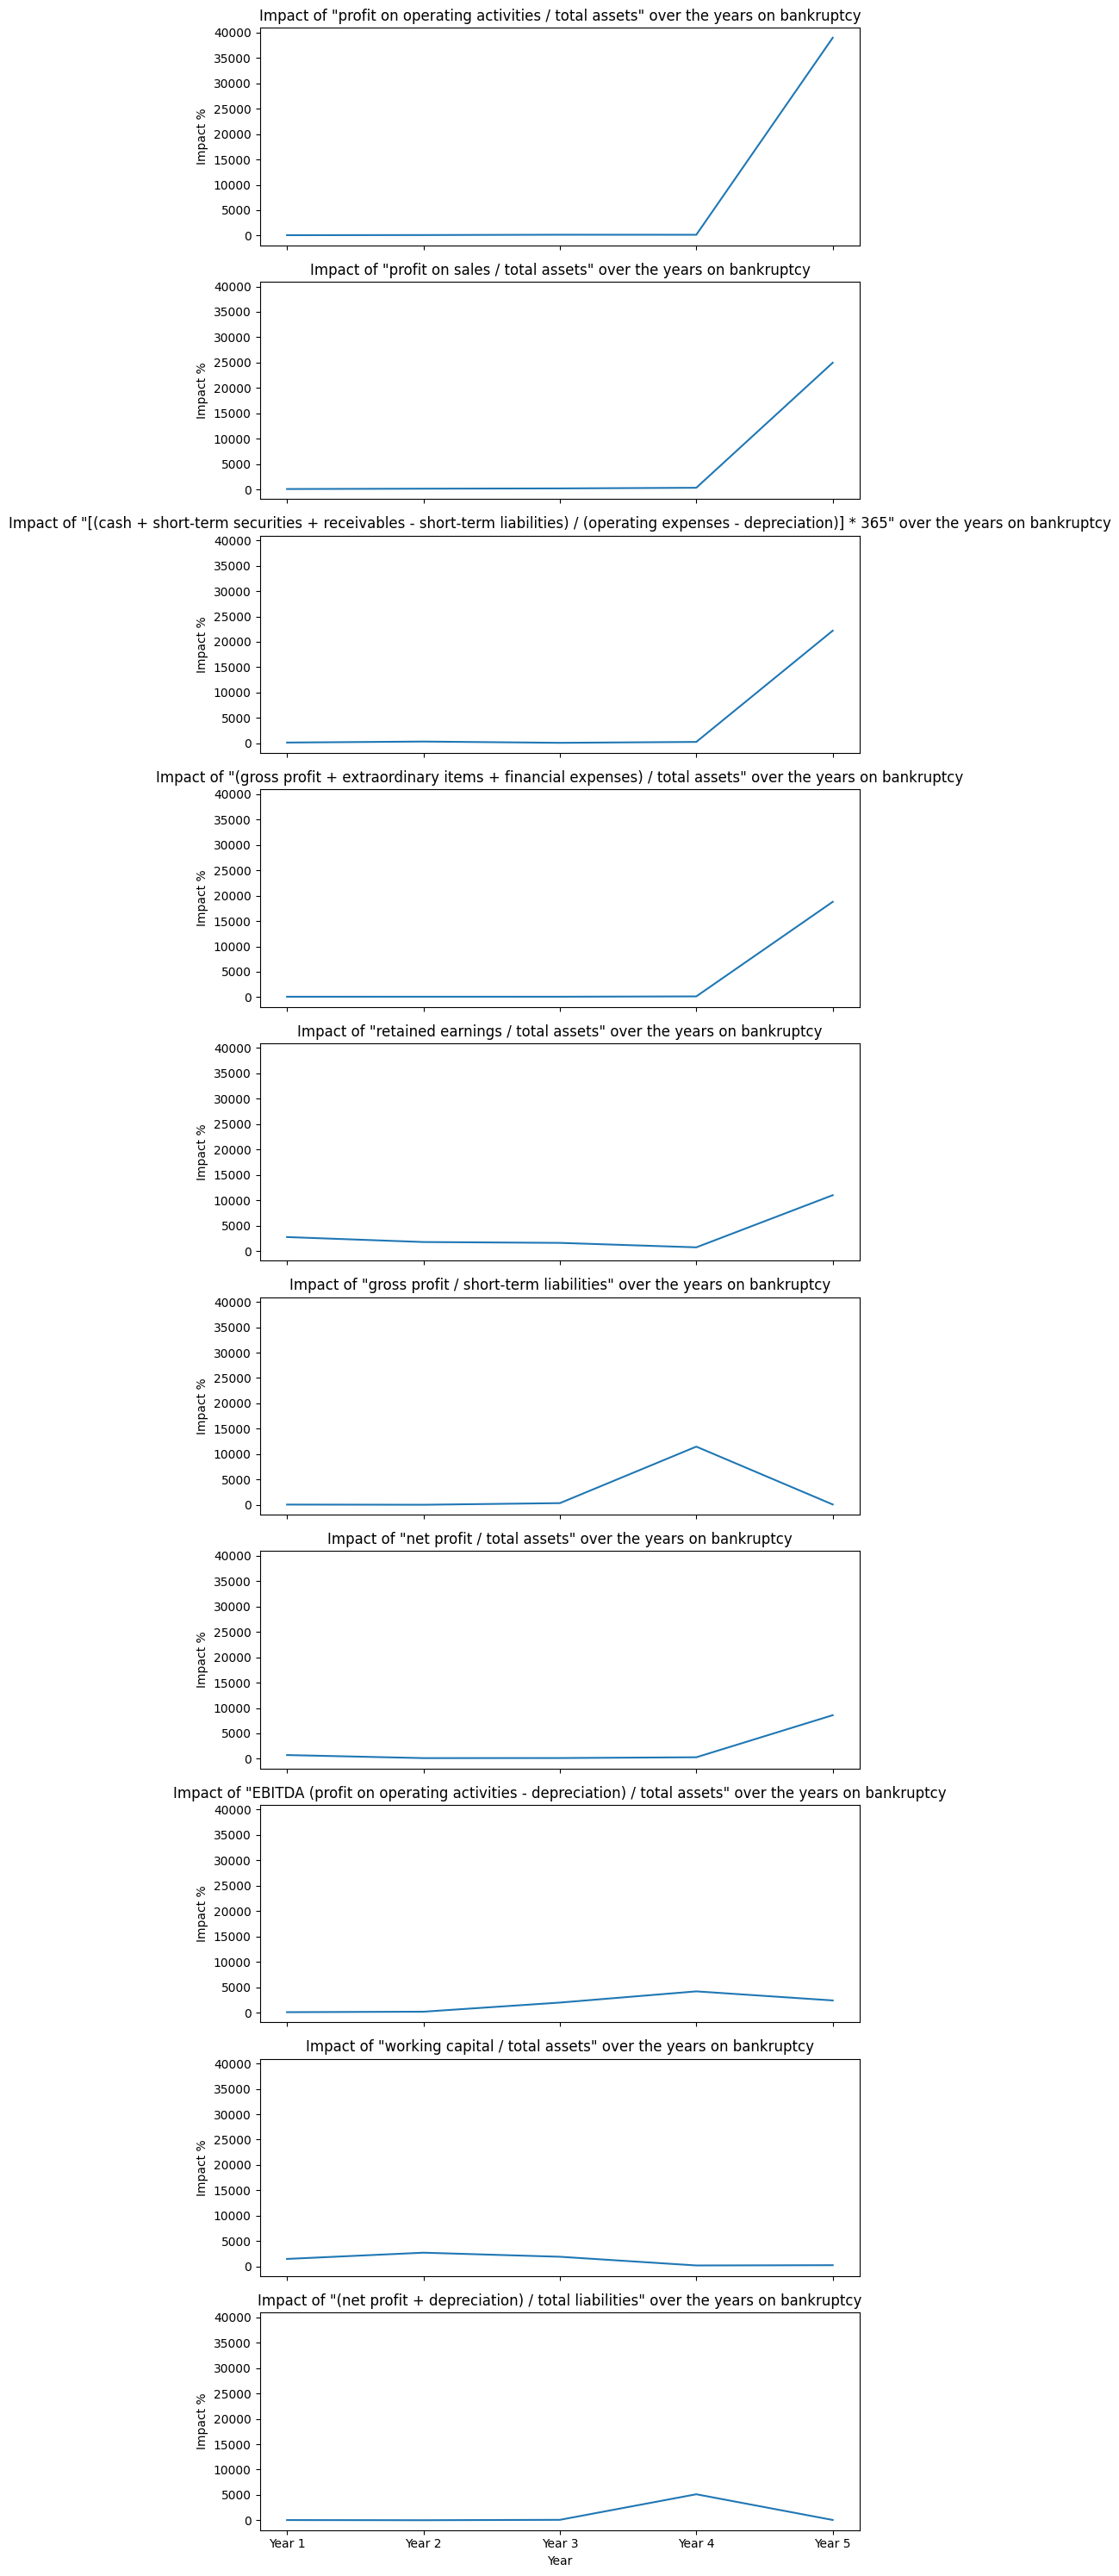

In [284]:
df_all_years = [df_year1, df_year2, df_year3, df_year4, df_year5]
years = ["Year 1", "Year 2", "Year 3", "Year 4", "Year 5"]

impactful_columns_trunc = impactful_columns[:10]


def plot_column_impact_over_years():
    fig, axs = plt.subplots(
        len(impactful_columns_trunc),
        1,
        sharex=True,
        sharey=True,
        figsize=(8, len(impactful_columns_trunc) * 3),
    )

    for i, column in enumerate(impactful_columns_trunc):
        ax = axs[i]
        values = []
        for dataFrame in df_all_years:
            columns = find_most_impactful_columns_from_year(dataFrame)
            value = list(filter(lambda x: x[0] == column[0], columns))
            values.append(value[0][1])
        ax.plot(years, values)
        ax.set_title(f'Impact of "{column[0]}" over the years on bankruptcy')
        ax.set_ylabel("Impact %")

    plt.xlabel("Year")
    plt.tight_layout()
    plt.show()


plot_column_impact_over_years()

In [409]:
most_impactful_columns_from_year = [
    {col[0]: col[1] for col in find_most_impactful_columns_from_year(dataFrame)}
    for dataFrame in df_all_years
]
df_most_impactful_columns_from_year = pd.DataFrame(most_impactful_columns_from_year)

Jest za dużo wierszy żeby to lepiej z wizualizować.\
Udało się znaleźć jakie dane mogą wskazywać na potencjalne bankructwo firmy.

In [387]:
def convert_column2(series: pd.Series):
    converted = pd.to_numeric(series, errors="coerce", downcast="float")
    converted = converted.replace([np.inf, -np.inf], np.nan)
    converted = converted.fillna(np.nan)
    return converted


def basic_preprocessing(dataFrame: pd.DataFrame):
    classes = dataFrame[names[64]]
    columns = dataFrame.columns.drop(names[64])

    df = dataFrame[columns].apply(lambda x: convert_column2(x))  # missing data

    imputer = SimpleImputer(missing_values=np.nan, strategy="median")  # missing data
    imputed_df = pd.DataFrame(imputer.fit_transform(df), columns=columns)

    scaler = StandardScaler()  # Standardization
    scaled_df = pd.DataFrame(
        scaler.fit_transform(imputed_df), columns=imputed_df.columns
    )

    return pd.concat([scaled_df, classes], axis=1)


def plot_grid(data: pd.DataFrame):
    grid = sns.PairGrid(data, hue=names[64])
    grid.map_diag(sns.histplot)
    grid.map_offdiag(sns.scatterplot)
    grid.add_legend()

In [261]:
scaled_df = basic_preprocessing(df_year1)
normalized_df = pd.DataFrame(normalize(scaled_df, norm="l2"), columns=scaled_df.columns)

In [285]:
def get_pca(dataFrame: pd.DataFrame, n_components=4):  # dowód na tę liczbe na końcu
    pca = PCA(n_components=n_components)
    pca_array = pca.fit_transform(dataFrame)

    return pd.DataFrame(
        data=pca_array, columns=[f"pca-{i+1}" for i in range(n_components)]
    )


def get_tsne(dataFrame: pd.DataFrame, n_components=3):
    tsne = TSNE(n_components=n_components)
    tsne_array = tsne.fit_transform(dataFrame)

    return pd.DataFrame(
        data=tsne_array, columns=[f"tsne-{i+1}" for i in range(n_components)]
    )

PCA (Principal Component Analysis) - Analiza głównych składowych:
PCA to technika używana do zmniejszenia liczby wymiarów w danych, jednocześnie zachowując jak najwięcej informacji. PCA szuka nowych "osi" (głównych składowych), które są kombinacjami liniowymi oryginalnych cech, tak aby zmaksymalizować wariancję. Główne składowe są uporządkowane według ilości wyjaśnionej wariancji, a wynikiem PCA są dane przekształcone do nowej przestrzeni o mniejszej liczbie wymiarów.

t-SNE (t-Distributed Stochastic Neighbor Embedding):
t-SNE to technika redukcji wymiarów, która koncentruje się na zachowaniu lokalnych struktur danych. Działa przez przekształcenie odległości między punktami w prawdopodobieństwa, a następnie minimalizuje różnicę między tymi prawdopodobieństwami w oryginalnej i zredukowanej przestrzeni. Wynikiem t-SNE są dane przekształcone do nowej przestrzeni (zwykle 2D lub 3D), która ułatwia wizualizację.

TSNE po preprocesie

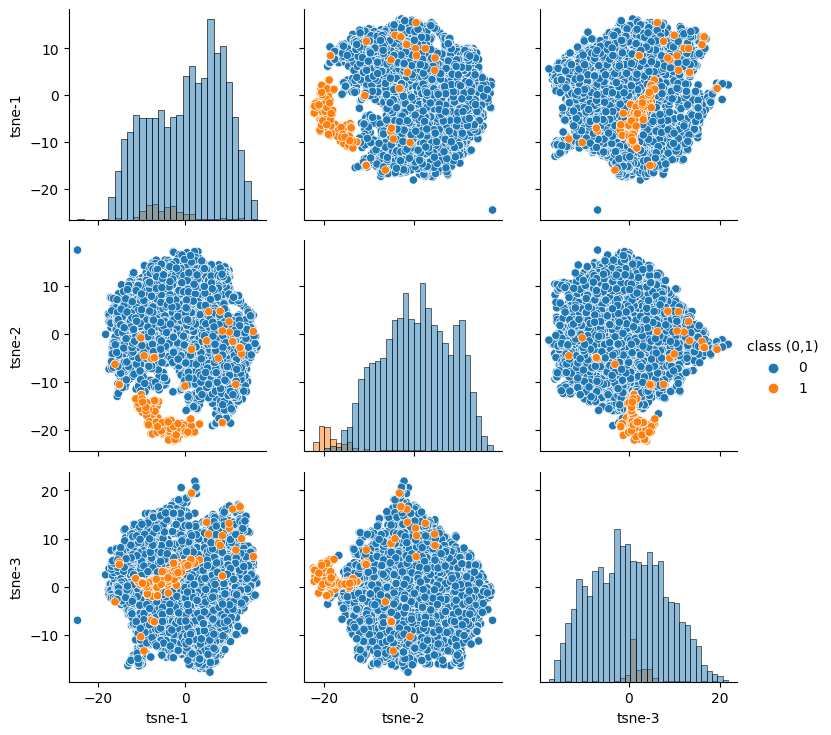

In [238]:
classes_scaled = df_year1[names[64]]
tsne_df = get_tsne(scaled_df)
tsne_df_classes = pd.concat([tsne_df, classes_scaled], axis=1)

plot_grid(tsne_df_classes)

TSNE po preprocesie i normalizacji

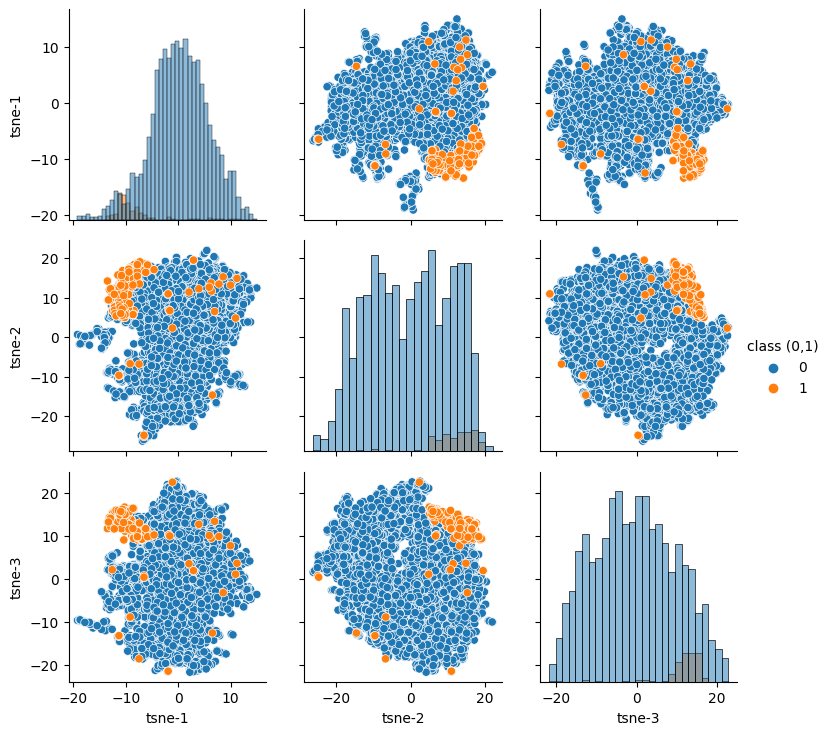

In [237]:
classes_normalized = df_year1[names[64]]
tsne_df = get_tsne(normalized_df)
tsne_df_classes = pd.concat([tsne_df, classes_normalized], axis=1)

plot_grid(tsne_df_classes)

Można zauważyć że w obu przypadkach jest wiele outlierów czyli danych mocno odchodzących od normy (skupiska)

In [286]:
pca_df_scaled = get_pca(scaled_df)

In [287]:
pca_df_normalized = get_pca(normalized_df)

TSNE po preprocesie i PCA

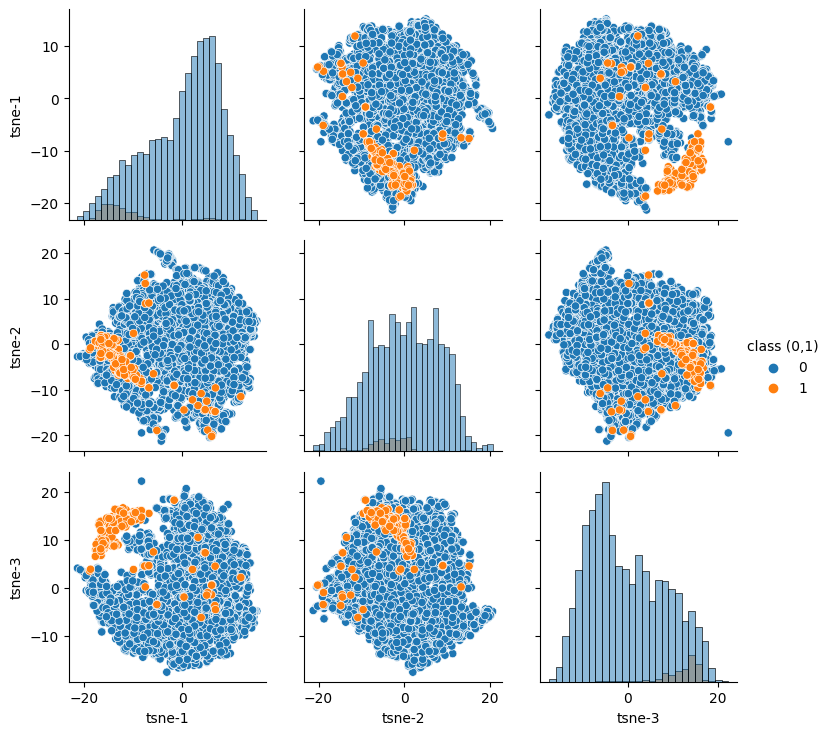

In [239]:
classes_scaled = df_year1[names[64]]
tsne_df = get_tsne(pca_df_scaled)
tsne_df_classes = pd.concat([tsne_df, classes_scaled], axis=1)

plot_grid(tsne_df_classes)

TSNE po preprocesie, normalizacji i PCA

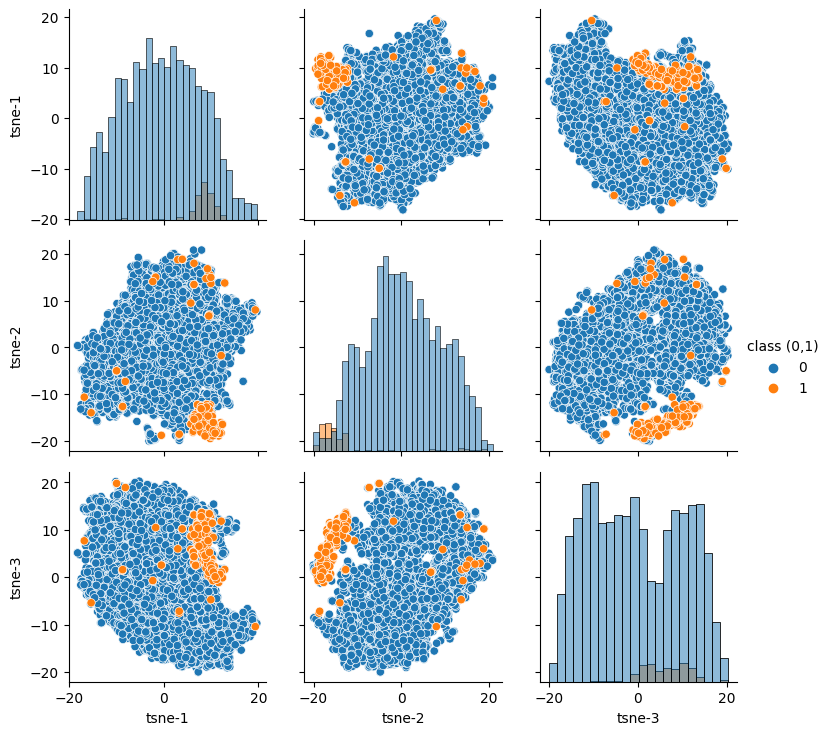

In [240]:
classes_normalized = df_year1[names[64]]
tsne_df = get_tsne(pca_df_normalized)
tsne_df_classes = pd.concat([tsne_df, classes_normalized], axis=1)

plot_grid(tsne_df_classes)

In [277]:
def remove_outliers(processed_df: pd.DataFrame, orginal_df: pd.DataFrame):
    y = orginal_df[names[64]]
    processed_df = processed_df.drop(names[64], axis=1)

    lof = LocalOutlierFactor()
    y_pred = lof.fit_predict(processed_df)

    X_clean = processed_df.loc[y_pred != -1]
    y_clean = y.loc[y_pred != -1]

    X_clean = pd.concat([X_clean, y_clean], axis=1)

    return X_clean


clean_scaled = remove_outliers(scaled_df, df_year1).reset_index(drop=True)
clean_normalized = remove_outliers(normalized_df, df_year1).reset_index(drop=True)

print(clean_scaled.shape, clean_normalized.shape)

(5927, 65) (6306, 65)


Local Outlier Factor (LOF) to algorytm, który służy do wykrywania wartości odstających (outlierów) w danych. Jest oparty na koncepcji estymacji gęstości lokalnej dla każdego punktu danych. LOF porównuje gęstość lokalną punktu danych z gęstością lokalną jego sąsiadów. Jeśli gęstość lokalna punktu danych jest znacznie niższa niż gęstość jego sąsiadów, uważa się go za wartość odstającą.

LOF działa w następujący sposób:

Dla każdego punktu danych oblicza się odległości do k najbliższych sąsiadów.
Na podstawie tych odległości oblicza się gęstość lokalną dla każdego punktu danych.
Porównuje się gęstość lokalną punktu danych z gęstościami lokalnymi jego sąsiadów i oblicza się współczynnik LOF.
Wartość LOF większa niż 1 oznacza, że dany punkt ma niższą gęstość lokalną niż jego sąsiedzi i może być uważany za wartość odstającą. Wartości LOF bliskie 1 wskazują, że punkt jest podobny do swoich sąsiadów i nie jest wartością odstającą.

In [288]:
classes_scaled = clean_scaled[names[64]]
pca_df_scaled = get_pca(clean_scaled)
# pca_df_classes = pd.concat([pca_df, classes], axis=1)
# plot_grid(pca_df_classes[:2]) #Wykresy się nie chcą zrobić nawet po [:2]

In [289]:
classes_normalized = clean_normalized[names[64]]
pca_df_normalized = get_pca(clean_normalized)
# pca_df_classes = pd.concat([pca_df, classes], axis=1)
# plot_grid(pca_df_classes[:2]) #Wykresy się nie chcą zrobić nawet po [:2]

TSNE po preprocesie i usuwaniu outlierów

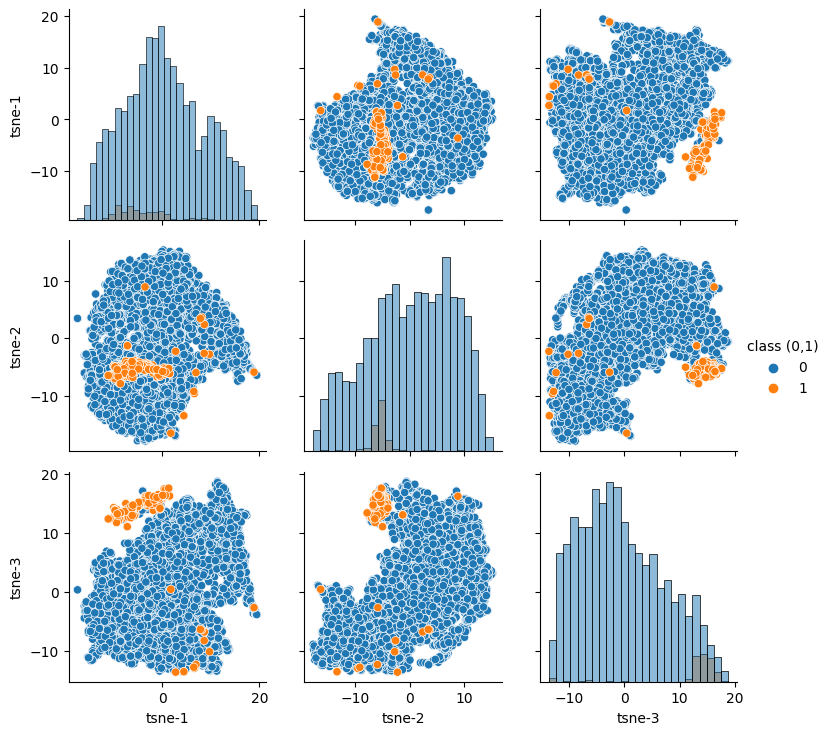

In [290]:
tsne_df = get_tsne(clean_scaled)
tsne_df_classes = pd.concat([tsne_df, classes_scaled], axis=1)

plot_grid(tsne_df_classes)

TSNE po preprocesie, normalizacji i usuwaniu outlierów

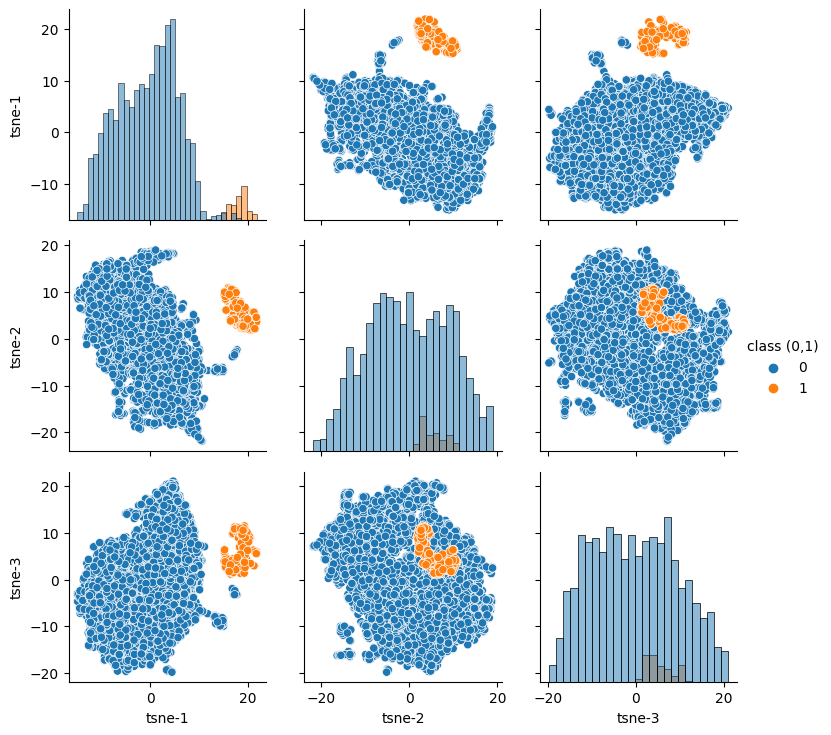

In [291]:
tsne_df = get_tsne(clean_normalized)
tsne_df_classes = pd.concat([tsne_df, classes_normalized], axis=1)

plot_grid(tsne_df_classes)

TSNE po preprocesie, usuwaniu outlierów i po PCA

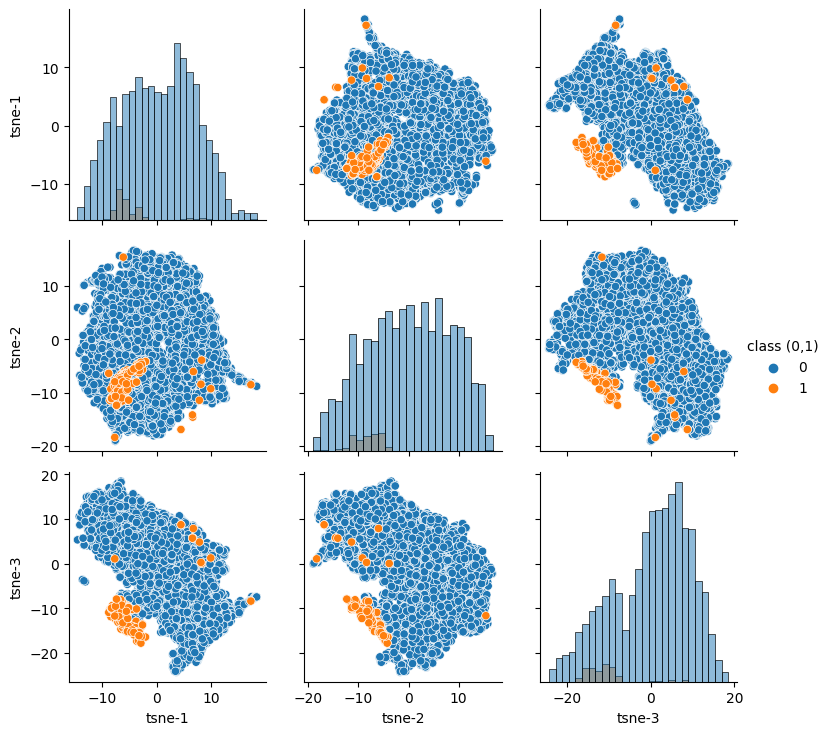

In [282]:
tsne_df = get_tsne(pca_df_scaled)
tsne_df_classes = pd.concat([tsne_df, classes_scaled], axis=1)

plot_grid(tsne_df_classes)

TSNE po preprocesie, normalizacji, usuwaniu outlierów i po PCA

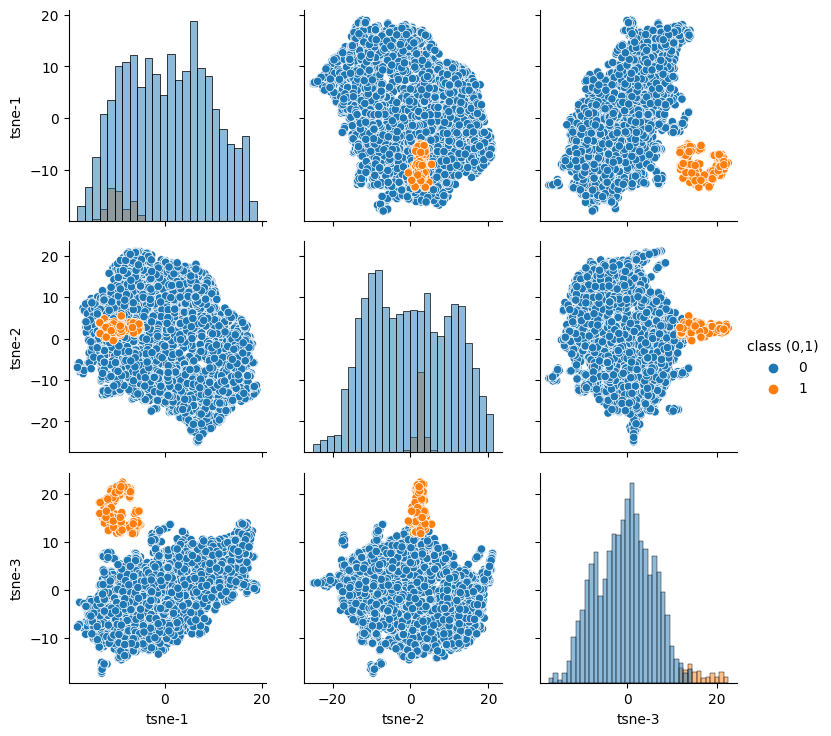

In [283]:
tsne_df = get_tsne(pca_df_normalized)
tsne_df_classes = pd.concat([tsne_df, classes_normalized], axis=1)

plot_grid(tsne_df_classes)

Można zauważyć całkiem spory wpływ normalizacji na grupowanie danych. Dzięki niej dane są bardziej zgrupowane na wykresie.

In [390]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from collections import namedtuple

Results = namedtuple(
    "Results",
    [
        "train_acc",
        "test_acc",
        "train_precision",
        "test_precision",
        "train_recall",
        "test_recall",
        "train_f1",
        "test_f1",
        "train_roc_auc",
        "test_roc_auc",
    ],
)


def preprocess_data(dataFrame: pd.DataFrame):
    basic = basic_preprocessing(dataFrame)
    normalized_df = pd.DataFrame(normalize(basic, norm="l2"), columns=basic.columns)
    clean_normalized = remove_outliers(normalized_df, dataFrame).reset_index(drop=True)

    return clean_normalized


def calculate_predictions(obj, X_train, X_test, y_train=None):
    obj.fit(X_train, y_train)
    y_train_pred = obj.predict(X_train)
    y_test_pred = obj.predict(X_test)

    return (y_train_pred, y_test_pred)


def get_results(y_train, y_test, y_train_pred, y_test_pred):
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)

    return Results(
        train_acc,
        test_acc,
        train_precision,
        test_precision,
        train_recall,
        test_recall,
        train_f1,
        test_f1,
        train_roc_auc,
        test_roc_auc,
    )


def print_results(title, results):
    print(title)
    print("Training accuracy:", results.train_acc * 100, "%")
    print("Testing accuracy:", results.test_acc * 100, "%")
    print("Training precision:", results.train_precision)
    print("Testing precision:", results.test_precision)
    print("Training recall:", results.train_recall)
    print("Testing recall:", results.test_recall)
    print("Training F1-score:", results.train_f1)
    print("Testing F1-score:", results.test_f1)
    print("Training ROC AUC:", results.train_roc_auc)
    print("Testing ROC AUC:", results.test_roc_auc)
    print()


def test_algoritms(dataFrame: pd.DataFrame):
    seed = 42

    X_train, X_test, y_train, y_test = train_test_split(
        dataFrame.drop(names[64], axis=1),
        dataFrame[names[64]],
        test_size=0.2,
        random_state=seed,
    )

    rfc = RandomForestClassifier(random_state=seed)
    [y_train_pred, y_test_pred] = calculate_predictions(
        rfc, X_train, X_test, y_train=y_train
    )
    results = get_results(y_train, y_test, y_train_pred, y_test_pred)
    print_results("Random Forest Classification:", results)

    lr = LogisticRegression(random_state=seed)
    [y_train_pred, y_test_pred] = calculate_predictions(
        lr, X_train, X_test, y_train=y_train
    )
    results = get_results(y_train, y_test, y_train_pred, y_test_pred)
    print_results("LogisticRegression:", results)

RandomForestClassifier:
To klasyfikator oparty na drzewach decyzyjnych. RandomForest tworzy wiele drzew decyzyjnych i dokonuje klasyfikacji poprzez uśrednienie wyników z tych drzew. Dzięki temu model jest bardziej odporny na przeuczenie się.

LogisticRegression:
To algorytm klasyfikacji, który modeluje prawdopodobieństwo przynależności do klasy za pomocą funkcji logistycznej. Jest to prosty i często stosowany algorytm do problemów klasyfikacji binarnej.

accuracy_score:
To miara oceny jakości klasyfikacji, która wyraża stosunek poprawnie sklasyfikowanych próbek do wszystkich próbek.

precision_score:
To miara, która ocenia, jak dobrze klasyfikator identyfikuje prawdziwie pozytywne przypadki, biorąc pod uwagę fałszywie pozytywne przypadki.

recall_score:
To miara, która ocenia, jak dobrze klasyfikator identyfikuje prawdziwie pozytywne przypadki, biorąc pod uwagę fałszywie negatywne przypadki.

f1_score:
To średnia harmoniczna precyzji i czułości. F1-wynik daje zrównoważoną ocenę jakości klasyfikacji, biorąc pod uwagę zarówno precyzję, jak i czułość.

roc_auc_score:
Krzywa ROC ilustruje zdolność klasyfikatora do rozróżniania między pozytywnymi i negatywnymi przypadkami, pokazując związek między czułością (recall) a specyficznością (1 - Fałszywy współczynnik pozytywny) dla różnych progów decyzyjnych. AUC (Area Under Curve) to pole pod krzywą ROC, które mierzy zdolność klasyfikatora do przewidywania prawdopodobieństw klas. Wartość AUC wynosi od 0,5 (klasyfikator losowy) do 1 (klasyfikator doskonały). W praktyce AUC powyżej 0,8 uważa się za bardzo dobrą wartość.

In [412]:
basic_preprocess = basic_preprocessing(df_year1)
preprocessed_data = preprocess_data(df_year1)
classes = preprocessed_data[names[64]]

pca_df = get_pca(preprocessed_data)
pca_df_classes = pd.concat([pca_df, classes], axis=1)

tsne_df = get_tsne(pca_df)
tsne_df_classes = pd.concat([tsne_df, classes], axis=1)

In [391]:
# test_algoritms(df_year1) error
classes = df_year1[names[64]]
columns = df_year1.columns.drop(names[64])
df_converted = df_year1[columns].apply(lambda x: convert_column2(x))
df = df_converted.fillna(0)
df = pd.concat([df, classes], axis=1)

test_algoritms(df)

Random Forest Classification:
Training accuracy: 100.0 %
Testing accuracy: 97.226173541963 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 0.23529411764705882
Training F1-score: 1.0
Testing F1-score: 0.38095238095238093
Training ROC AUC: 1.0
Testing ROC AUC: 0.6176470588235294

LogisticRegression:
Training accuracy: 96.08610567514677 %
Testing accuracy: 96.01706970128022 %
Training precision: 0.5
Testing precision: 0.0
Training recall: 0.00909090909090909
Testing recall: 0.0
Training F1-score: 0.01785714285714286
Testing F1-score: 0.0
Training ROC AUC: 0.5043603036474726
Testing ROC AUC: 0.4981549815498155



c:\Users\ep20254\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [392]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
imputed_df_median = pd.DataFrame(imputer.fit_transform(df_converted), columns=columns)

df_median = pd.concat([imputed_df_median, classes], axis=1)

test_algoritms(df_median)

Random Forest Classification:
Training accuracy: 100.0 %
Testing accuracy: 96.94167852062589 %
Training precision: 1.0
Testing precision: 0.9
Training recall: 1.0
Testing recall: 0.17647058823529413
Training F1-score: 1.0
Testing F1-score: 0.2950819672131148
Training ROC AUC: 1.0
Testing ROC AUC: 0.5878662904276102

LogisticRegression:
Training accuracy: 96.03273438889877 %
Testing accuracy: 95.94594594594594 %
Training precision: 0.2857142857142857
Testing precision: 0.0
Training recall: 0.00909090909090909
Testing recall: 0.0
Training F1-score: 0.017621145374449337
Testing F1-score: 0.0
Training ROC AUC: 0.5040825773004999
Testing ROC AUC: 0.4977859778597786



c:\Users\ep20254\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [393]:
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputed_df_mean = pd.DataFrame(imputer.fit_transform(df_converted), columns=columns)

df_mean = pd.concat([imputed_df_mean, classes], axis=1)

test_algoritms(df_mean)

Random Forest Classification:
Training accuracy: 100.0 %
Testing accuracy: 98.29302987197724 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 0.5294117647058824
Training F1-score: 1.0
Testing F1-score: 0.6923076923076924
Training ROC AUC: 1.0
Testing ROC AUC: 0.7647058823529411

LogisticRegression:
Training accuracy: 96.01494396014944 %
Testing accuracy: 96.23044096728307 %
Training precision: 0.16666666666666666
Testing precision: 0.0
Training recall: 0.004545454545454545
Testing recall: 0.0
Training F1-score: 0.008849557522123894
Testing F1-score: 0.0
Training ROC AUC: 0.5018098500277727
Testing ROC AUC: 0.4992619926199262



c:\Users\ep20254\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [394]:
imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
imputed_df_mf = pd.DataFrame(imputer.fit_transform(df_converted), columns=columns)

df_mf = pd.concat([imputed_df_mf, classes], axis=1)

test_algoritms(df_mf)

c:\Users\ep20254\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


Random Forest Classification:
Training accuracy: 100.0 %
Testing accuracy: 97.15504978662874 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 0.21568627450980393
Training F1-score: 1.0
Testing F1-score: 0.3548387096774193
Training ROC AUC: 1.0
Testing ROC AUC: 0.607843137254902

LogisticRegression:
Training accuracy: 96.06831524639745 %
Testing accuracy: 96.08819345661452 %
Training precision: 0.3333333333333333
Testing precision: 0.0
Training recall: 0.004545454545454545
Testing recall: 0.0
Training F1-score: 0.008968609865470852
Testing F1-score: 0.0
Training ROC AUC: 0.5020875763747454
Testing ROC AUC: 0.4985239852398524



c:\Users\ep20254\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Wynika z tego że w tym przypadku strategy='mean' daje najlepsze wyniki. Jeszcze należy sprawdzić co się stanie po standaryzacji.

In [395]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(
    scaler.fit_transform(imputed_df_median), columns=imputed_df_median.columns
)
scaled_df = pd.concat([scaled_df, classes], axis=1)

test_algoritms(scaled_df)

Random Forest Classification:
Training accuracy: 100.0 %
Testing accuracy: 96.94167852062589 %
Training precision: 1.0
Testing precision: 0.9
Training recall: 1.0
Testing recall: 0.17647058823529413
Training F1-score: 1.0
Testing F1-score: 0.2950819672131148
Training ROC AUC: 1.0
Testing ROC AUC: 0.5878662904276102

LogisticRegression:
Training accuracy: 96.08610567514677 %
Testing accuracy: 96.15931721194879 %
Training precision: 0.5
Testing precision: 0.2857142857142857
Training recall: 0.00909090909090909
Testing recall: 0.0392156862745098
Training F1-score: 0.01785714285714286
Testing F1-score: 0.06896551724137931
Training ROC AUC: 0.5043603036474726
Testing ROC AUC: 0.5177628246870705



In [396]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(
    scaler.fit_transform(imputed_df_mean), columns=imputed_df_mean.columns
)
scaled_df = pd.concat([scaled_df, classes], axis=1)

test_algoritms(scaled_df)

Random Forest Classification:
Training accuracy: 100.0 %
Testing accuracy: 98.36415362731152 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 0.5490196078431373
Training F1-score: 1.0
Testing F1-score: 0.7088607594936709
Training ROC AUC: 1.0
Testing ROC AUC: 0.7745098039215687

LogisticRegression:
Training accuracy: 96.08610567514677 %
Testing accuracy: 96.15931721194879 %
Training precision: 0.5
Testing precision: 0.2857142857142857
Training recall: 0.00909090909090909
Testing recall: 0.0392156862745098
Training F1-score: 0.01785714285714286
Testing F1-score: 0.06896551724137931
Training ROC AUC: 0.5043603036474726
Testing ROC AUC: 0.5177628246870705



In [397]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(
    scaler.fit_transform(imputed_df_mf), columns=imputed_df_mf.columns
)
scaled_df = pd.concat([scaled_df, classes], axis=1)

test_algoritms(scaled_df)

Random Forest Classification:
Training accuracy: 100.0 %
Testing accuracy: 97.36842105263158 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 0.27450980392156865
Training F1-score: 1.0
Testing F1-score: 0.43076923076923085
Training ROC AUC: 1.0
Testing ROC AUC: 0.6372549019607843

LogisticRegression:
Training accuracy: 96.08610567514677 %
Testing accuracy: 96.15931721194879 %
Training precision: 0.5
Testing precision: 0.2857142857142857
Training recall: 0.00909090909090909
Testing recall: 0.0392156862745098
Training F1-score: 0.01785714285714286
Testing F1-score: 0.06896551724137931
Training ROC AUC: 0.5043603036474726
Testing ROC AUC: 0.5177628246870705



Po standaryzacji LogisticRegression nie odczuwa wpływu strategii na wynik. Dla RFC strategy="mean" jest najkorzystniejsza.

In [398]:
test_algoritms(basic_preprocess)

Random Forest Classification:
Training accuracy: 100.0 %
Testing accuracy: 96.94167852062589 %
Training precision: 1.0
Testing precision: 0.9
Training recall: 1.0
Testing recall: 0.17647058823529413
Training F1-score: 1.0
Testing F1-score: 0.2950819672131148
Training ROC AUC: 1.0
Testing ROC AUC: 0.5878662904276102

LogisticRegression:
Training accuracy: 96.08610567514677 %
Testing accuracy: 96.15931721194879 %
Training precision: 0.5
Testing precision: 0.2857142857142857
Training recall: 0.00909090909090909
Testing recall: 0.0392156862745098
Training F1-score: 0.01785714285714286
Testing F1-score: 0.06896551724137931
Training ROC AUC: 0.5043603036474726
Testing ROC AUC: 0.5177628246870705



In [399]:
test_algoritms(preprocessed_data)

Random Forest Classification:
Training accuracy: 100.0 %
Testing accuracy: 96.59270998415214 %
Training precision: 1.0
Testing precision: 0.8333333333333334
Training recall: 1.0
Testing recall: 0.19607843137254902
Training F1-score: 1.0
Testing F1-score: 0.31746031746031744
Training ROC AUC: 1.0
Testing ROC AUC: 0.5972134518547303

LogisticRegression:
Training accuracy: 96.1736716891356 %
Testing accuracy: 95.95879556259905 %
Training precision: 0.0
Testing precision: 0.0
Training recall: 0.0
Testing recall: 0.0
Training F1-score: 0.0
Testing F1-score: 0.0
Training ROC AUC: 0.5
Testing ROC AUC: 0.5



c:\Users\ep20254\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ep20254\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [400]:
test_algoritms(pca_df_classes)

Random Forest Classification:
Training accuracy: 100.0 %
Testing accuracy: 100.0 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 1.0
Training F1-score: 1.0
Testing F1-score: 1.0
Training ROC AUC: 1.0
Testing ROC AUC: 1.0

LogisticRegression:
Training accuracy: 100.0 %
Testing accuracy: 100.0 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 1.0
Training F1-score: 1.0
Testing F1-score: 1.0
Training ROC AUC: 1.0
Testing ROC AUC: 1.0



In [418]:
pca_df = get_pca(preprocessed_data, n_components=3)
pca_df_classes = pd.concat([pca_df, classes], axis=1)

test_algoritms(pca_df_classes)

Random Forest Classification:
Training accuracy: 100.0 %
Testing accuracy: 97.22662440570524 %
Training precision: 1.0
Testing precision: 0.8333333333333334
Training recall: 1.0
Testing recall: 0.39215686274509803
Training F1-score: 1.0
Testing F1-score: 0.5333333333333333
Training ROC AUC: 1.0
Testing ROC AUC: 0.6944269037094606

LogisticRegression:
Training accuracy: 96.1736716891356 %
Testing accuracy: 95.95879556259905 %
Training precision: 0.0
Testing precision: 0.0
Training recall: 0.0
Testing recall: 0.0
Training F1-score: 0.0
Testing F1-score: 0.0
Training ROC AUC: 0.5
Testing ROC AUC: 0.5



c:\Users\ep20254\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ep20254\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [419]:
pca_df = get_pca(preprocessed_data, n_components=4)
pca_df_classes = pd.concat([pca_df, classes], axis=1)

test_algoritms(pca_df_classes)

Random Forest Classification:
Training accuracy: 100.0 %
Testing accuracy: 100.0 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 1.0
Training F1-score: 1.0
Testing F1-score: 1.0
Training ROC AUC: 1.0
Testing ROC AUC: 1.0

LogisticRegression:
Training accuracy: 100.0 %
Testing accuracy: 100.0 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 1.0
Training F1-score: 1.0
Testing F1-score: 1.0
Training ROC AUC: 1.0
Testing ROC AUC: 1.0



dowód że liczbę komponentów PCA można ustawić na 4

In [420]:
test_algoritms(tsne_df_classes)

Random Forest Classification:
Training accuracy: 100.0 %
Testing accuracy: 100.0 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 1.0
Training F1-score: 1.0
Testing F1-score: 1.0
Training ROC AUC: 1.0
Testing ROC AUC: 1.0

LogisticRegression:
Training accuracy: 100.0 %
Testing accuracy: 100.0 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 1.0
Training F1-score: 1.0
Testing F1-score: 1.0
Training ROC AUC: 1.0
Testing ROC AUC: 1.0



In [402]:
def full_test(dataFrame: pd.DataFrame):
    preprocessed_data = preprocess_data(dataFrame)
    classes = preprocessed_data[names[64]]

    pca_df = get_pca(preprocessed_data)

    tsne_df = get_tsne(pca_df)
    tsne_df_classes = pd.concat([tsne_df, classes], axis=1)

    test_algoritms(tsne_df_classes)

In [403]:
print("Year1")
full_test(df_year1)

Year1
Random Forest Classification:
Training accuracy: 100.0 %
Testing accuracy: 100.0 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 1.0
Training F1-score: 1.0
Testing F1-score: 1.0
Training ROC AUC: 1.0
Testing ROC AUC: 1.0

LogisticRegression:
Training accuracy: 100.0 %
Testing accuracy: 100.0 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 1.0
Training F1-score: 1.0
Testing F1-score: 1.0
Training ROC AUC: 1.0
Testing ROC AUC: 1.0



In [404]:
print("Year2")
full_test(df_year2)

Year2
Random Forest Classification:
Training accuracy: 100.0 %
Testing accuracy: 100.0 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 1.0
Training F1-score: 1.0
Testing F1-score: 1.0
Training ROC AUC: 1.0
Testing ROC AUC: 1.0

LogisticRegression:
Training accuracy: 100.0 %
Testing accuracy: 100.0 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 1.0
Training F1-score: 1.0
Testing F1-score: 1.0
Training ROC AUC: 1.0
Testing ROC AUC: 1.0



In [405]:
print("Year3")
full_test(df_year3)

Year3
Random Forest Classification:
Training accuracy: 100.0 %
Testing accuracy: 100.0 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 1.0
Training F1-score: 1.0
Testing F1-score: 1.0
Training ROC AUC: 1.0
Testing ROC AUC: 1.0

LogisticRegression:
Training accuracy: 100.0 %
Testing accuracy: 100.0 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 1.0
Training F1-score: 1.0
Testing F1-score: 1.0
Training ROC AUC: 1.0
Testing ROC AUC: 1.0



In [406]:
print("Year4")
full_test(df_year4)

Year4
Random Forest Classification:
Training accuracy: 100.0 %
Testing accuracy: 100.0 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 1.0
Training F1-score: 1.0
Testing F1-score: 1.0
Training ROC AUC: 1.0
Testing ROC AUC: 1.0

LogisticRegression:
Training accuracy: 100.0 %
Testing accuracy: 100.0 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 1.0
Training F1-score: 1.0
Testing F1-score: 1.0
Training ROC AUC: 1.0
Testing ROC AUC: 1.0



In [407]:
print("Year5")
full_test(df_year5)

Year5
Random Forest Classification:
Training accuracy: 100.0 %
Testing accuracy: 100.0 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 1.0
Training F1-score: 1.0
Testing F1-score: 1.0
Training ROC AUC: 1.0
Testing ROC AUC: 1.0

LogisticRegression:
Training accuracy: 100.0 %
Testing accuracy: 100.0 %
Training precision: 1.0
Testing precision: 1.0
Training recall: 1.0
Testing recall: 1.0
Training F1-score: 1.0
Testing F1-score: 1.0
Training ROC AUC: 1.0
Testing ROC AUC: 1.0

